In [1]:
import os
from glob import glob
import dask
import xarray as xr
import cartopy.crs as ccrs
import cartopy
import numpy as np
from netCDF4 import Dataset
from scipy.io import loadmat
from xgcm import Grid
from xgcm.autogenerate import generate_grid_ds
from cmocean import cm

from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/utils.py:137: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  RuntimeWarning,


In [2]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
w = cluster.scale(1)

In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

<Client: 'tcp://10.148.0.70:35174' processes=0 threads=0, memory=0 B>

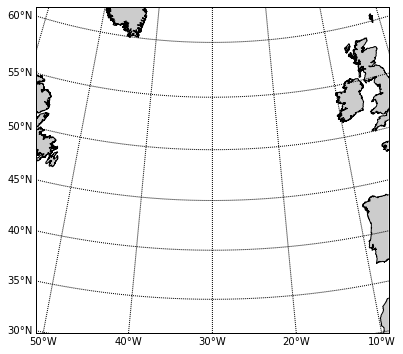

In [15]:
#import os
#os.environ['PROJ_LIB'] = '/opt/conda/pkgs/proj4-5.2.0-he1b5a44_1003/share/proj'
#from mpl_toolkits.basemap import Basemap

m = Basemap(width=4000000,height=3700000,
            rsphere=(6378137.00,6356752.3142),\
            resolution='i',area_thresh=1000.,projection='lcc',\
            lat_1=30.,lat_2=35,lat_0=48,lon_0=-30.)


fig, ax = plt.subplots(1,1,figsize=(9.,6.))

m.drawcoastlines()
m.fillcontinents()
m.drawmapboundary()
m.drawparallels(np.arange(-60,80,5),labels=[1,0,0,0])
m.drawmeridians(np.arange(-150,150,10),labels=[0,0,0,1])

levels = np.arange(0,0.101,0.001)



## 1. Read AVISO .nc data, and save as chunked .zarr data

In [6]:
# .nc data downloaded from the AVISO center (2 years, daily, num. 731)
AVISO_data_folder = '/home1/datawork/xyu/OSMOSIS_llc4320/data_store/AVISO/'
# the path where the data will be re-stored
out_dir_nc = '/home1/scratch/xyu/OSMOSIS_llc4320/nc_file/'

filenames = sorted(glob(AVISO_data_folder+'dt_global_allsat_madt_uv_*.nc')) 
print('Number of files processed: %d' %len(filenames))

aviso_nc = Dataset(filenames[0],'r')  
aviso_nc

Number of files processed: 731


<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    cdm_data_type: Grid
    title: DT merged Global Ocean Gridded Absolute Geostrophic Velocities SSALTO/Duacs L4 product
    summary: This dataset contains Delayed Time Level-4 absolute geostrophic velocities products from multi-satellite observations over Global Ocean.
    comment: Surface product; Absolute Geostrophic Velocities
    time_coverage_resolution: P1D
    product_version: 5.0
    institution: CNES, CLS
    project: SSALTO/DUACS
    references: www.aviso.altimetry.fr
    contact: aviso@altimetry.fr
    license: http://www.aviso.altimetry.fr/fileadmin/documents/data/License_Aviso.pdf
    platform: Cryosat-2, Envisat Extension Phase, Jason-1 New Orbit, Jason-2
    date_created: 2014-02-28 17:45:17
    history: 2014-02-28 17:45:17:creation
    Conventions: CF-1.6
    standard_name_vocabulary: http://cf-pcmdi.llnl.gov/documents/cf-standard-names/standard-name-table/12/cf-standard-n

In [ ]:
time = aviso_nc.variables['time'][:]
time = np.array(time)
u = aviso_nc.variables['u'][:]
u = np.array(u)
v = aviso_nc.variables['v'][:]
v = np.array(v)

ds = xr.Dataset({'u':(('time','lat','lon'),u),'v':(('time','lat','lon'),v)}, {'time':time,'lati':(('lat','lon'),yv),'loni':(('lat','lon'),xv)})
ds

In [9]:
filenames = sorted(glob(AVISO_data_folder+'dt_global_allsat_madt_uv_*.nc')) 
print('Number of files processed: %d' %len(filenames))

# store in netcdf files
fsize_bound = 5*1e6

for i in np.arange(len(filenames)):

    #
    file_out = out_dir_nc+'/madt_uv_t%03d.nc'%(i)
          
    if not os.path.isfile(file_out) or os.path.getsize(file_out) < fsize_bound:            
        
        aviso_nc = Dataset(filenames[i],'r')         
        lat = aviso_nc.variables['lat'][:]
        lat = np.array(lat)
        lon = aviso_nc.variables['lon'][:]
        lon = np.array(lon)
        time = aviso_nc.variables['time'][:]
        time = np.array(time)
        u = aviso_nc.variables['u'][:]
        u = np.array(u)
        v = aviso_nc.variables['v'][:]
        v = np.array(v)
        ds = xr.Dataset({'u':(('time','lat','lon'),u),'v':(('time','lat','lon'),v)}, {'time':time,'lat':lat,'lon':lon})
        
        # ds = np.real(ds).rename(v)
        ds = ds.load() # this may be required in order to prevent pickle related errors
        
        while True:
            try:
                ds.to_netcdf(file_out, mode='w', unlimited_dims=['time'])

            except:
                print('failure')
            break

    else:
        print('t=%d - allready processed'%(i))      

Number of files processed: 731


In [10]:
filenames = sorted(glob(out_dir_nc+'madt_uv_t*.nc')) 
print('Number of files processed: %d' %len(filenames))
%time ds = xr.open_mfdataset(filenames, concat_dim='time', compat='equals')
print(ds)

Number of files processed: 731


/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: In xarray version 0.14 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  """Entry point for launching an IPython kernel.
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/xarray/backends/api.py:934: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continu

CPU times: user 4.64 s, sys: 1.59 s, total: 6.23 s
Wall time: 6.36 s
<xarray.Dataset>
Dimensions:  (lat: 720, lon: 1440, time: 731)
Coordinates:
  * lat      (lat) float32 -89.875 -89.625 -89.375 ... 89.375 89.625 89.875
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.375 359.625 359.875
  * time     (time) float64 2.264e+04 2.265e+04 ... 2.337e+04 2.338e+04
Data variables:
    u        (time, lat, lon) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    v        (time, lat, lon) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>


In [130]:
chunks = {'time': 1, 'lat': 720, 'lon': 1440}
ds = ds.chunk(chunks)
print(ds)

<xarray.Dataset>
Dimensions:  (lat: 720, lon: 1440, time: 731)
Coordinates:
  * lat      (lat) float32 -89.875 -89.625 -89.375 -89.125 -88.875 -88.625 ...
  * lon      (lon) float32 0.125 0.375 0.625 0.875 1.125 1.375 1.625 1.875 ...
  * time     (time) float64 2.264e+04 2.265e+04 2.265e+04 2.265e+04 ...
Data variables:
    u        (time, lat, lon) float64 dask.array<shape=(731, 720, 1440), chunksize=(1, 720, 1440)>
    v        (time, lat, lon) float64 dask.array<shape=(731, 720, 1440), chunksize=(1, 720, 1440)>


In [131]:
out_dir_zarr = '/home1/datawork/xyu/OSMOSIS_llc4320/data_store/'

file_out = out_dir_zarr+'/AVISO_uv_total_rechunk.zarr'
%time ds.to_zarr(file_out, mode='w')     

CPU times: user 4.8 s, sys: 356 ms, total: 5.15 s
Wall time: 6.63 s


# 2. Read rechunked data

In [32]:
out_dir_zarr = '/home1/datawork/xyu/OSMOSIS_llc4320/data_store/'
ds = xr.open_zarr(out_dir_zarr+'AVISO_uv_total_rechunk.zarr')
print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

<xarray.Dataset>
Dimensions:  (lat: 720, lon: 1440, time: 731)
Coordinates:
  * lat      (lat) float32 -89.875 -89.625 -89.375 ... 89.375 89.625 89.875
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.375 359.625 359.875
  * time     (time) float64 2.264e+04 2.265e+04 ... 2.337e+04 2.338e+04
Data variables:
    u        (time, lat, lon) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    v        (time, lat, lon) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>

 data size: 12.1 GB


In [33]:
ds_full = generate_grid_ds(ds, {'X':'lon', 'Y':'lat'})
ds_full

<xarray.Dataset>
Dimensions:   (lat: 720, lat_left: 720, lon: 1440, lon_left: 1440, time: 731)
Coordinates:
  * lat       (lat) float32 -89.875 -89.625 -89.375 ... 89.375 89.625 89.875
  * lon       (lon) float32 0.125 0.375 0.625 0.875 ... 359.375 359.625 359.875
  * time      (time) float64 2.264e+04 2.265e+04 ... 2.337e+04 2.338e+04
  * lon_left  (lon_left) float32 0.0 0.25 0.5 0.75 ... 359.0 359.25 359.5 359.75
  * lat_left  (lat_left) float32 -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75
Data variables:
    u         (time, lat, lon) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    v         (time, lat, lon) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>

In [34]:
# define (real) time
def iters_to_date(iters, delta_t=24*3600.):
    t0 = datetime.datetime(2012,1,1)    
    ltime = delta_t * (np.array(iters))
    dtime = [t0+dateutil.relativedelta.relativedelta(seconds=t) for t in ltime]    
    return dtime

In [35]:
time_day = iters_to_date(np.arange(731))

In [36]:
# data for the coarse-graining approach
ds_full = ds_full.assign_coords(time=time_day) 
print(ds_full)

<xarray.Dataset>
Dimensions:   (lat: 720, lat_left: 720, lon: 1440, lon_left: 1440, time: 731)
Coordinates:
  * lat       (lat) float32 -89.875 -89.625 -89.375 ... 89.375 89.625 89.875
  * lon       (lon) float32 0.125 0.375 0.625 0.875 ... 359.375 359.625 359.875
  * time      (time) datetime64[ns] 2012-01-01 2012-01-02 ... 2013-12-31
  * lon_left  (lon_left) float32 0.0 0.25 0.5 0.75 ... 359.0 359.25 359.5 359.75
  * lat_left  (lat_left) float32 -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75
Data variables:
    u         (time, lat, lon) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    v         (time, lat, lon) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>


In [37]:
grid = Grid(ds_full, periodic=['X','Y'])
grid

<xgcm.Grid>
X Axis (periodic):
  * center   lon --> left
  * left     lon_left --> center
Y Axis (periodic):
  * center   lat --> left
  * left     lat_left --> center

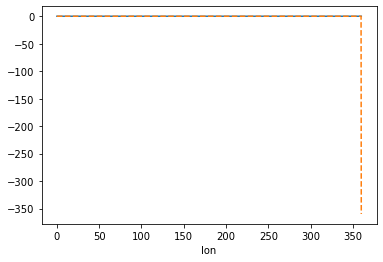

In [38]:
dlong = grid.diff(ds_full.lon, 'X', boundary_discontinuity=360)
dlonc = grid.diff(ds_full.lon_left, 'X', boundary_discontinuity=360)
dlonc_wo_discontinuity = grid.diff(ds_full.lon_left, 'X')

dlatg = grid.diff(ds_full.lat, 'Y', boundary='fill', fill_value=np.nan)
dlatc = grid.diff(ds_full.lat_left, 'Y', boundary='fill', fill_value=np.nan)
dlatg[0]=0.25
dlatc[-1]=0.25

dlonc.plot()
dlonc_wo_discontinuity.plot(linestyle='--')

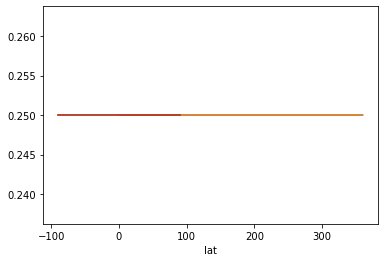

In [39]:
dlonc.plot()
dlong.plot()
dlatg.plot()
dlatc.plot()

In [40]:
def dll_dist(dlon, dlat, lon, lat):
        """Converts lat/lon differentials into distances in meters

        PARAMETERS
        ----------
        dlon : xarray.DataArray longitude differentials
        dlat : xarray.DataArray latitude differentials
        lon  : xarray.DataArray longitude values
        lat  : xarray.DataArray latitude values

        RETURNS
        -------
        dx  : xarray.DataArray distance inferred from dlon
        dy  : xarray.DataArray distance inferred from dlat
        """

        distance_1deg_equator = 111000.0
        
        dx = dlon * xr.ufuncs.cos(xr.ufuncs.deg2rad(lat)) * distance_1deg_equator
        dy = ((lon * 0) + 1) * dlat * distance_1deg_equator
        return dx, dy

In [41]:
ds_full.coords['dxg'], ds_full.coords['dyg'] = dll_dist(dlong, dlatg, ds_full.lon, ds_full.lat)
ds_full.coords['dxc'], ds_full.coords['dyc'] = dll_dist(dlonc, dlatc, ds_full.lon, ds_full.lat)
ds_full.coords['area_c'] = ds_full.dxc * ds_full.dyc
ds_full

<xarray.Dataset>
Dimensions:   (lat: 720, lat_left: 720, lon: 1440, lon_left: 1440, time: 731)
Coordinates:
  * lat       (lat) float32 -89.875 -89.625 -89.375 ... 89.375 89.625 89.875
  * lon       (lon) float32 0.125 0.375 0.625 0.875 ... 359.375 359.625 359.875
  * time      (time) datetime64[ns] 2012-01-01 2012-01-02 ... 2013-12-31
  * lon_left  (lon_left) float32 0.0 0.25 0.5 0.75 ... 359.0 359.25 359.5 359.75
  * lat_left  (lat_left) float32 -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75
    dxg       (lon_left, lat) float32 60.542812 181.6231 ... 181.6231 60.542812
    dyg       (lon, lat_left) float32 27750.0 27750.0 ... 27750.0 27750.0
    dxc       (lon, lat) float32 60.542812 181.6231 ... 181.6231 60.542812
    dyc       (lon, lat) float32 27750.0 27750.0 27750.0 ... 27750.0 27750.0
    area_c    (lon, lat) float32 1680063.0 5040041.0 ... 5040041.0 1680063.0
Data variables:
    u         (time, lat, lon) float64 dask.array<chunksize=(1, 720, 1440), meta=np.ndarray>
    v    

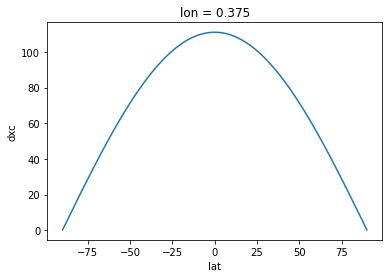

In [42]:
(ds_full.dxc*4/1000).isel(lon=1).plot()


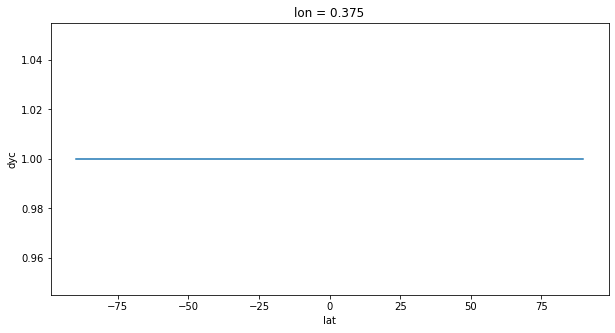

In [43]:
fig, ax = plt.subplots(figsize=(10,5))
ax = plt.subplot(111)
(ds_full.dyc*4/111000).isel(lon=1).plot()
#ax.set_ylim([-2, 2])


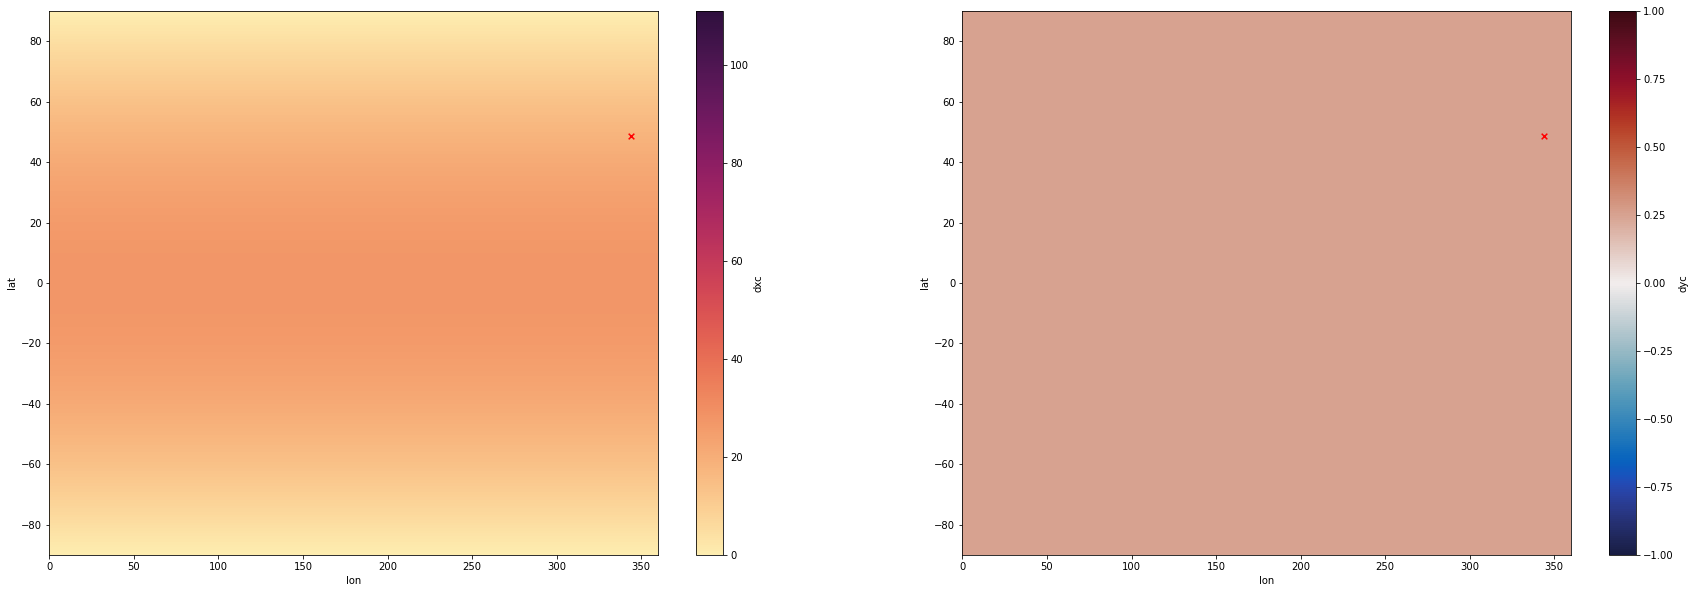

In [44]:
fig = plt.figure(figsize=(30,10))

ax = plt.subplot(121)
(ds_full.dxc/1000).plot(x='lon',y='lat',vmin=0,vmax=111,cmap=cm.matter)
ax.scatter(343.8125,48.6875,s=32,marker='x',color='r')

ax = plt.subplot(122)
(ds_full.dyc/111000).plot(x='lon',y='lat',vmin=-1,vmax=1,cmap=cm.balance)
ax.scatter(343.8125,48.6875,s=32,marker='x',color='r')

In [46]:
du_dx = grid.diff(ds_full.u.where(ds_full.u>-20), 'X') / ds_full.dxg
du_dx_ij = grid.interp(du_dx, 'X')
du_dx_ij

<xarray.DataArray 'mul-56a2744fe84a0366a36bf982aecc15e2' (time: 731, lat: 720, lon: 1440)>
dask.array<mul, shape=(731, 720, 1440), dtype=float64, chunksize=(1, 720, 1438), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2012-01-01 2012-01-02 ... 2013-12-31
  * lat      (lat) float32 -89.875 -89.625 -89.375 ... 89.375 89.625 89.875
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.375 359.625 359.875

In [47]:
du_dy = grid.diff(ds_full.u.where(ds_full.u>-20), 'Y') / ds_full.dyg
du_dy_ij = grid.interp(du_dy, 'Y')
du_dy_ij

<xarray.DataArray 'mul-7a8b560b85542952f32a9d2febd1b2c0' (time: 731, lat: 720, lon: 1440)>
dask.array<mul, shape=(731, 720, 1440), dtype=float64, chunksize=(1, 718, 1440), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2012-01-01 2012-01-02 ... 2013-12-31
  * lat      (lat) float32 -89.875 -89.625 -89.375 ... 89.375 89.625 89.875
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.375 359.625 359.875

In [48]:
dv_dx = grid.diff(ds_full.v.where(ds_full.u>-20), 'X') / ds_full.dxg
dv_dx_ij = grid.interp(dv_dx, 'X')
dv_dx_ij

<xarray.DataArray 'mul-80d39e75f63bf9ca576f16106aefc301' (time: 731, lat: 720, lon: 1440)>
dask.array<mul, shape=(731, 720, 1440), dtype=float64, chunksize=(1, 720, 1438), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2012-01-01 2012-01-02 ... 2013-12-31
  * lat      (lat) float32 -89.875 -89.625 -89.375 ... 89.375 89.625 89.875
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.375 359.625 359.875

In [49]:
dv_dy = grid.diff(ds_full.v.where(ds_full.u>-20), 'Y') / ds_full.dyg
dv_dy_ij = grid.interp(dv_dy, 'Y')
dv_dy_ij

<xarray.DataArray 'mul-48e5a522b762e48846b120c823ef1ef3' (time: 731, lat: 720, lon: 1440)>
dask.array<mul, shape=(731, 720, 1440), dtype=float64, chunksize=(1, 718, 1440), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2012-01-01 2012-01-02 ... 2013-12-31
  * lat      (lat) float32 -89.875 -89.625 -89.375 ... 89.375 89.625 89.875
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.375 359.625 359.875

In [43]:
u_m = ds_full.u.interp(lat=48.6875,lon=343.8125)
v_m = ds_full.v.interp(lat=48.6875,lon=343.8125)
u_m

<xarray.DataArray 'u' (time: 731)>
dask.array<_interpnd, shape=(731,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 2.264e+04 2.265e+04 ... 2.337e+04 2.338e+04
    dxc      float64 1.832e+04
    dyc      float64 2.775e+04
    area_c   float64 5.084e+08
    lat      float64 48.69
    lon      float64 343.8

In [ ]:
(ds_full.u.interp(lat=48.6875,lon=343.8125).sel(time=slice('2012-09-05', '2013-09-5'))).plot()
(ds_full.u.sel(lat=48.6875,lon=343.8125,method='nearest').sel(time=slice('2012-09-05', '2013-09-5'))).plot()

(ds_full.v.interp(lat=48.6875,lon=343.8125).sel(time=slice('2012-09-05', '2013-09-5'))).plot()
(ds_full.v.sel(lat=48.6875,lon=343.8125,method='nearest').sel(time=slice('2012-09-05', '2013-09-5'))).plot()


# 3. Save data 
#### i. nearest to the central mooring site, 
#### ii. interpolate into the central mooring site

In [44]:
du_dx_m = du_dx_ij.sel(lat=48.6875,lon=343.8125,method='nearest')
du_dy_m = du_dy_ij.sel(lat=48.6875,lon=343.8125,method='nearest')
dv_dx_m = dv_dx_ij.sel(lat=48.6875,lon=343.8125,method='nearest')
dv_dy_m = dv_dy_ij.sel(lat=48.6875,lon=343.8125,method='nearest')
u_m = ds_full.u.sel(lat=48.6875,lon=343.8125,method='nearest')
v_m = ds_full.v.sel(lat=48.6875,lon=343.8125,method='nearest')

du_dx_m = np.real(du_dx_m).rename('du_dx_m')
du_dy_m = np.real(du_dy_m).rename('du_dy_m')
dv_dx_m = np.real(dv_dx_m).rename('dv_dx_m')
dv_dy_m = np.real(dv_dy_m).rename('dv_dy_m')
u_m = np.real(u_m).rename('u_m')
v_m = np.real(v_m).rename('v_m')

ddm = xr.merge([du_dx_m,du_dy_m,dv_dx_m,dv_dy_m,u_m,v_m])
ddm

out_dir_zarr = '/home1/datawork/xyu/OSMOSIS_llc4320/data_store/'

file_out = out_dir_zarr+'/AVISO_ddm.nc'
%time ddm.to_netcdf(file_out, mode='w')     

CPU times: user 34 s, sys: 1.75 s, total: 35.7 s
Wall time: 1min 17s


In [45]:
du_dx_m = du_dx_ij.interp(lat=48.6875,lon=343.8125)
du_dy_m = du_dy_ij.interp(lat=48.6875,lon=343.8125)
dv_dx_m = dv_dx_ij.interp(lat=48.6875,lon=343.8125)
dv_dy_m = dv_dy_ij.interp(lat=48.6875,lon=343.8125)
u_m = ds_full.u.interp(lat=48.6875,lon=343.8125)
v_m = ds_full.v.interp(lat=48.6875,lon=343.8125)

du_dx_m = np.real(du_dx_m).rename('du_dx_m')
du_dy_m = np.real(du_dy_m).rename('du_dy_m')
dv_dx_m = np.real(dv_dx_m).rename('dv_dx_m')
dv_dy_m = np.real(dv_dy_m).rename('dv_dy_m')
u_m = np.real(u_m).rename('u_m')
v_m = np.real(v_m).rename('v_m')

ddm = xr.merge([u_m,v_m,du_dx_m,du_dy_m,dv_dx_m,dv_dy_m])
ddm

out_dir_zarr = '/home1/datawork/xyu/OSMOSIS_llc4320/data_store/'

file_out = out_dir_zarr+'/AVISO_ddm_interp.nc'
%time ddm.to_netcdf(file_out, mode='w')   

CPU times: user 35.8 s, sys: 1.78 s, total: 37.6 s
Wall time: 1min 21s


## 4. Some figures 

## Results at the mooring site

(-0.4, 0.4)

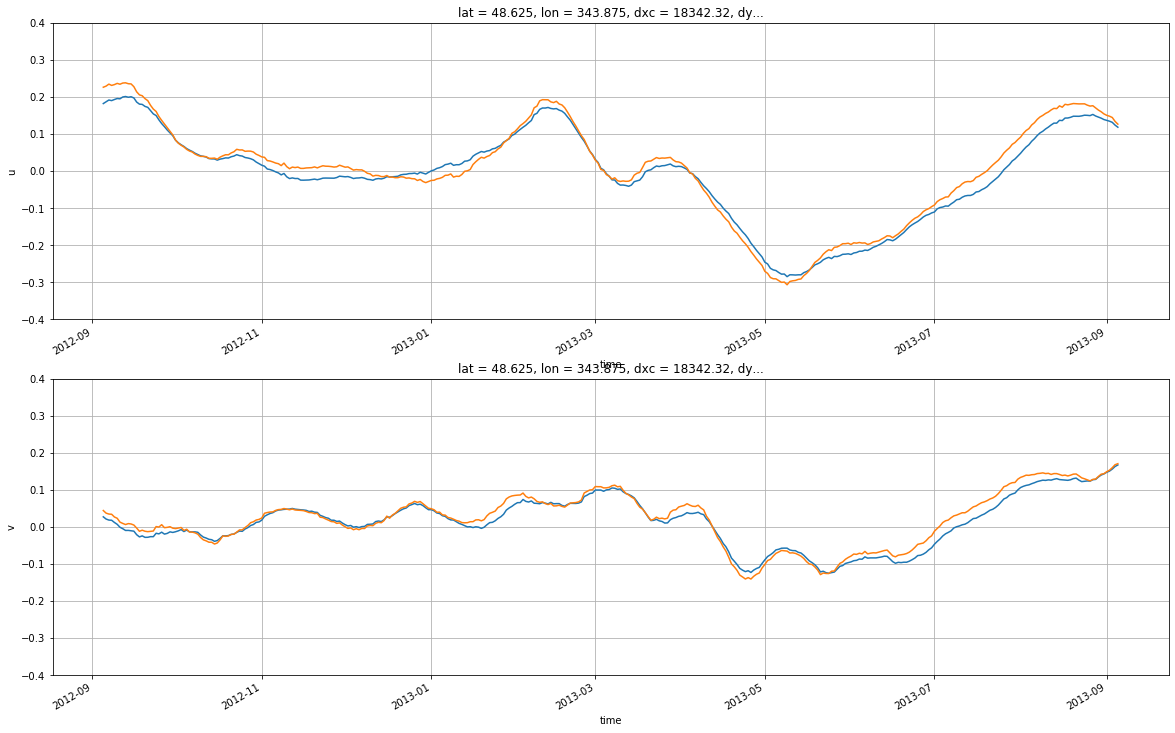

In [26]:
fig = plt.figure(figsize=(20,12))

ax = plt.subplot(211)
(ds_full.u.interp(lat=48.6875,lon=343.8125).sel(time=slice('2012-09-05', '2013-09-5'))).plot()
(ds_full.u.sel(lat=48.6875,lon=343.8125,method='nearest').sel(time=slice('2012-09-05', '2013-09-5'))).plot()
ax.grid()
ax.set_ylim([-0.3, 0.3])

ax = plt.subplot(212)
(ds_full.v.interp(lat=48.6875,lon=343.8125).sel(time=slice('2012-09-05', '2013-09-5'))).plot()
(ds_full.v.sel(lat=48.6875,lon=343.8125,method='nearest').sel(time=slice('2012-09-05', '2013-09-5'))).plot()
ax.grid()
ax.set_ylim([-0.3, 0.3])

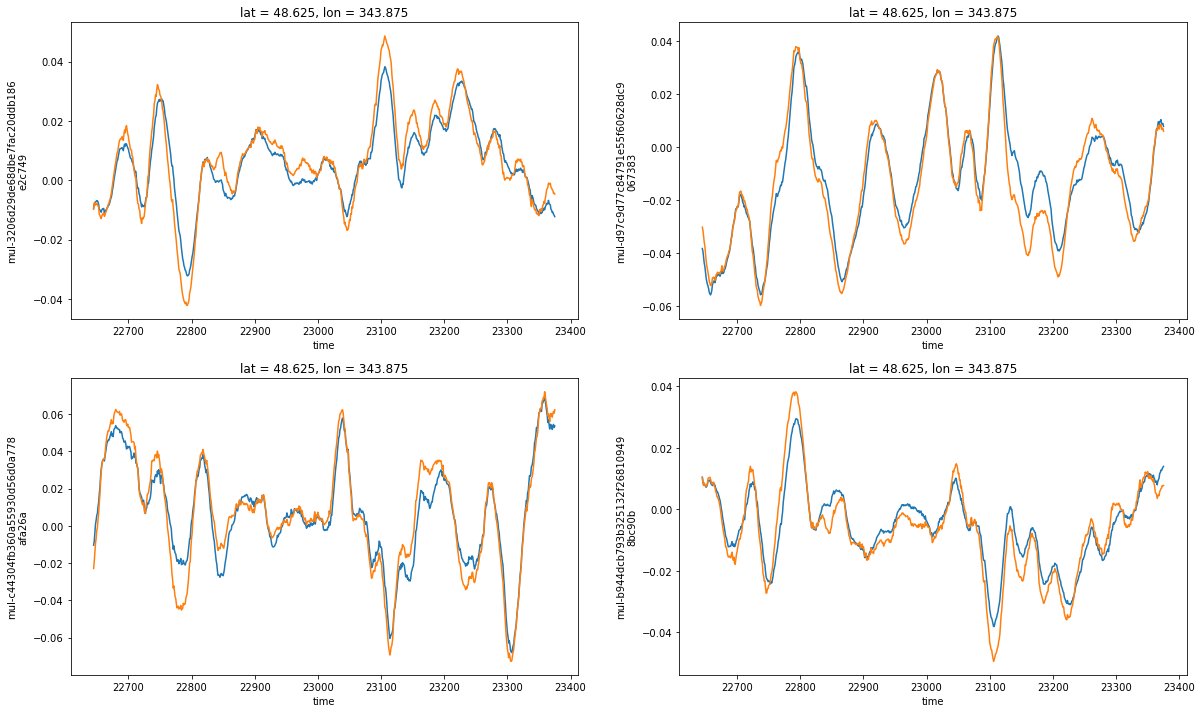

In [56]:
f_m = 2*omega*np.sin(np.deg2rad(48.6875))

fig = plt.figure(figsize=(20,12))

ax = plt.subplot(221)
(du_dx_ij.interp(lat=48.6875,lon=343.8125)/f_m).plot()
(du_dx_ij.sel(lat=48.6875,lon=343.8125,method='nearest')/f_m).plot()

ax = plt.subplot(222)
(du_dy_ij.interp(lat=48.6875,lon=343.8125)/f_m).plot()
(du_dy_ij.sel(lat=48.6875,lon=343.8125,method='nearest')/f_m).plot()

ax = plt.subplot(223)
(dv_dx_ij.interp(lat=48.6875,lon=343.8125)/f_m).plot()
(dv_dx_ij.sel(lat=48.6875,lon=343.8125,method='nearest')/f_m).plot()

ax = plt.subplot(224)
(dv_dy_ij.interp(lat=48.6875,lon=343.8125)/f_m).plot()
(dv_dy_ij.sel(lat=48.6875,lon=343.8125,method='nearest')/f_m).plot()

In [25]:
lon_grid, lat_grid = np.meshgrid(ds.lon, ds.lat)
omega = 7.3/100000
f = 2*omega*np.sin(np.deg2rad(lat_grid))
f

array([[-0.000146  , -0.000146  , -0.000146  , ..., -0.000146  ,
        -0.000146  , -0.000146  ],
       [-0.000146  , -0.000146  , -0.000146  , ..., -0.000146  ,
        -0.000146  , -0.000146  ],
       [-0.00014599, -0.00014599, -0.00014599, ..., -0.00014599,
        -0.00014599, -0.00014599],
       ...,
       [ 0.00014599,  0.00014599,  0.00014599, ...,  0.00014599,
         0.00014599,  0.00014599],
       [ 0.000146  ,  0.000146  ,  0.000146  , ...,  0.000146  ,
         0.000146  ,  0.000146  ],
       [ 0.000146  ,  0.000146  ,  0.000146  , ...,  0.000146  ,
         0.000146  ,  0.000146  ]], dtype=float32)

### divergence/f

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '


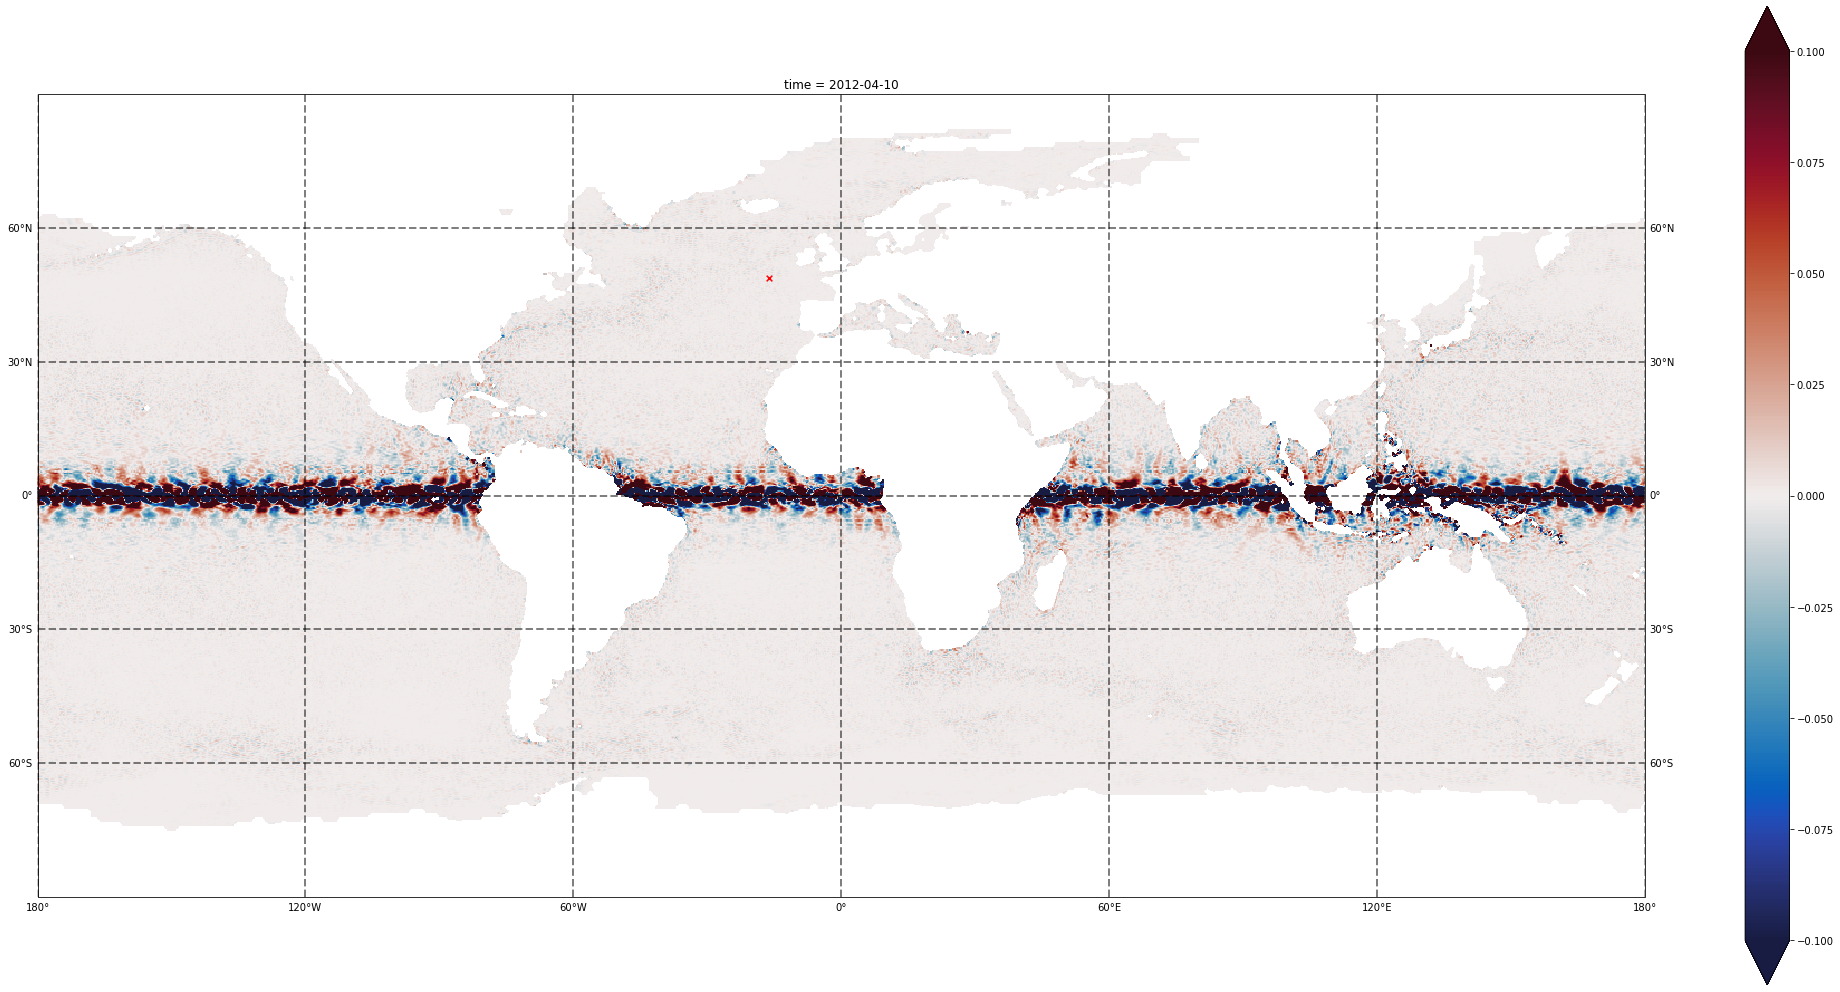

In [52]:
div_f = ((du_dx_ij+dv_dy_ij)/f).isel(time=100)

fig = plt.figure(figsize=(36,18))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
#ax.coastlines()
#ax.gridlines()
div_f.plot.pcolormesh(ax=ax, x='lon', y='lat', transform=ccrs.PlateCarree(), vmin=-.1, vmax=.1,cmap=cm.balance)
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False
ax.scatter(343.8125,48.6875,s=32,marker='x',color='r')

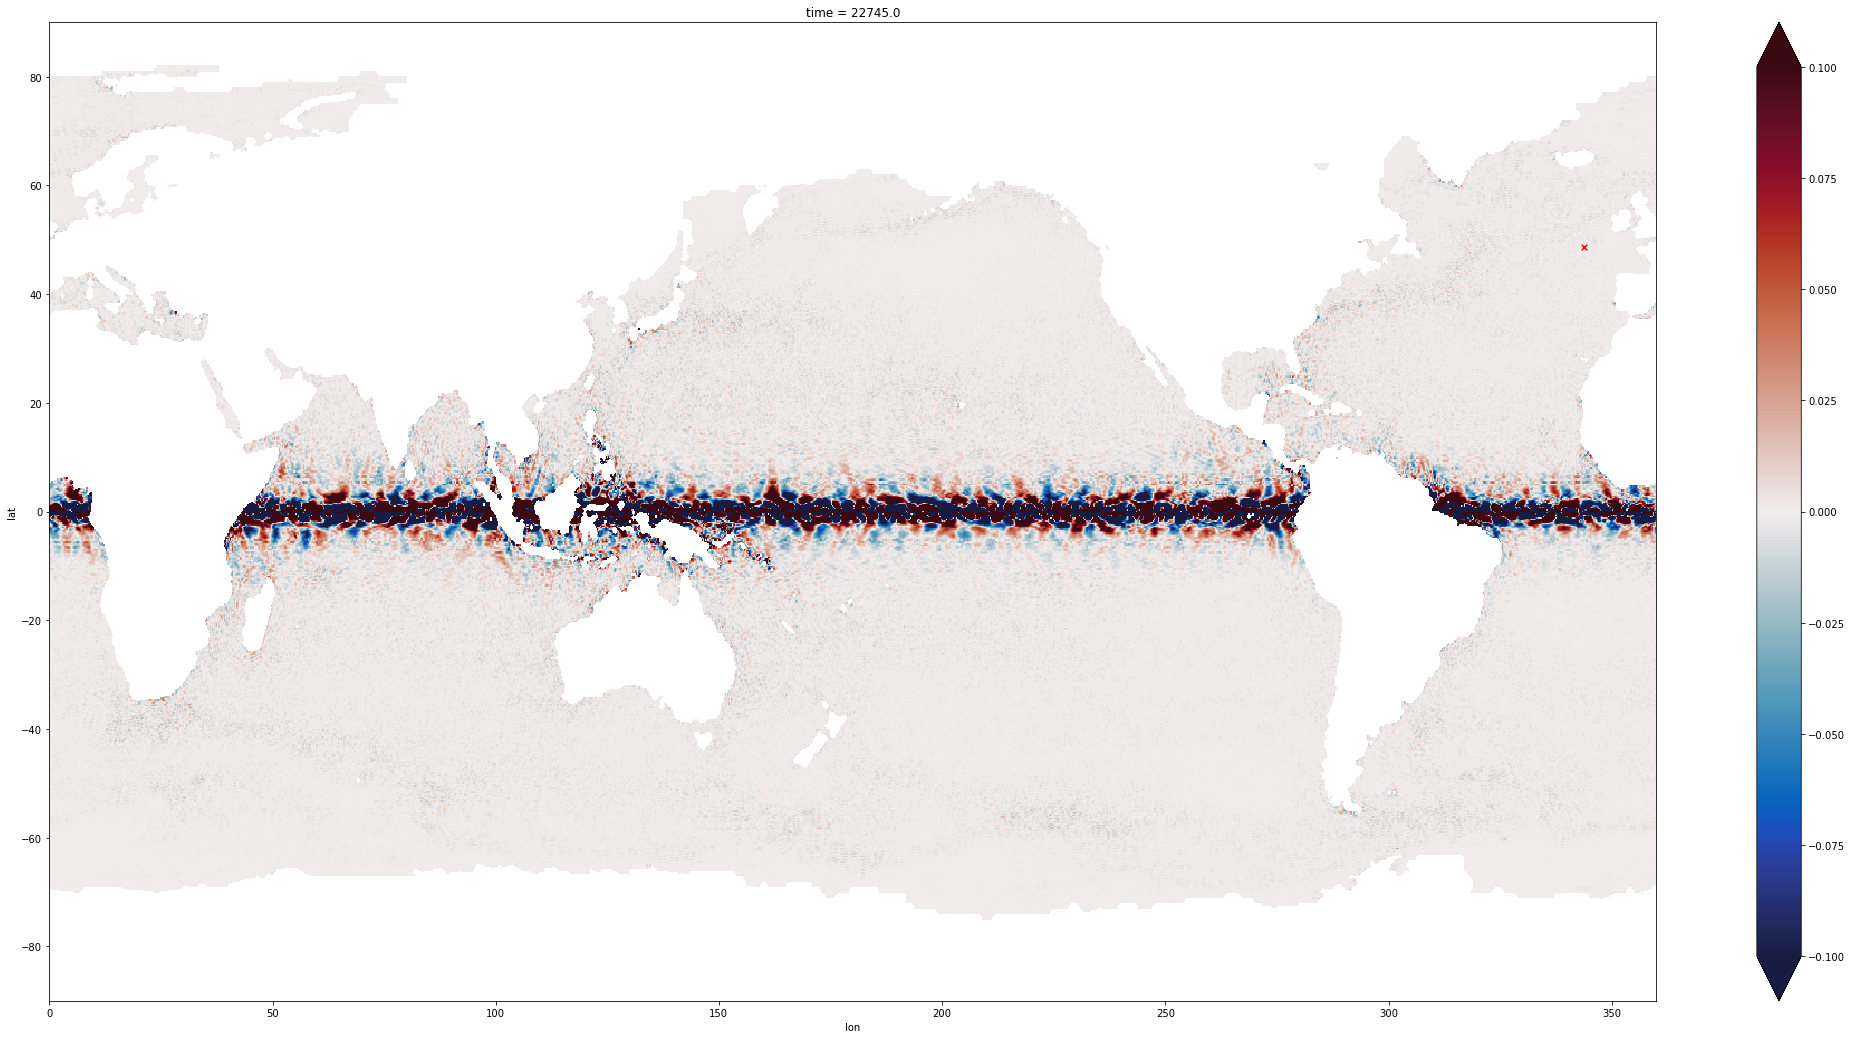

In [60]:
# divergence/f
fig = plt.figure(figsize=(36,18))
ax = plt.subplot(111)
((du_dx_ij+dv_dy_ij)/f).isel(time=100).plot(x='lon',y='lat',vmin=-.1,vmax=.1,cmap=cm.balance)
ax.scatter(343.8125,48.6875,s=32,marker='x',color='r')

### divergence

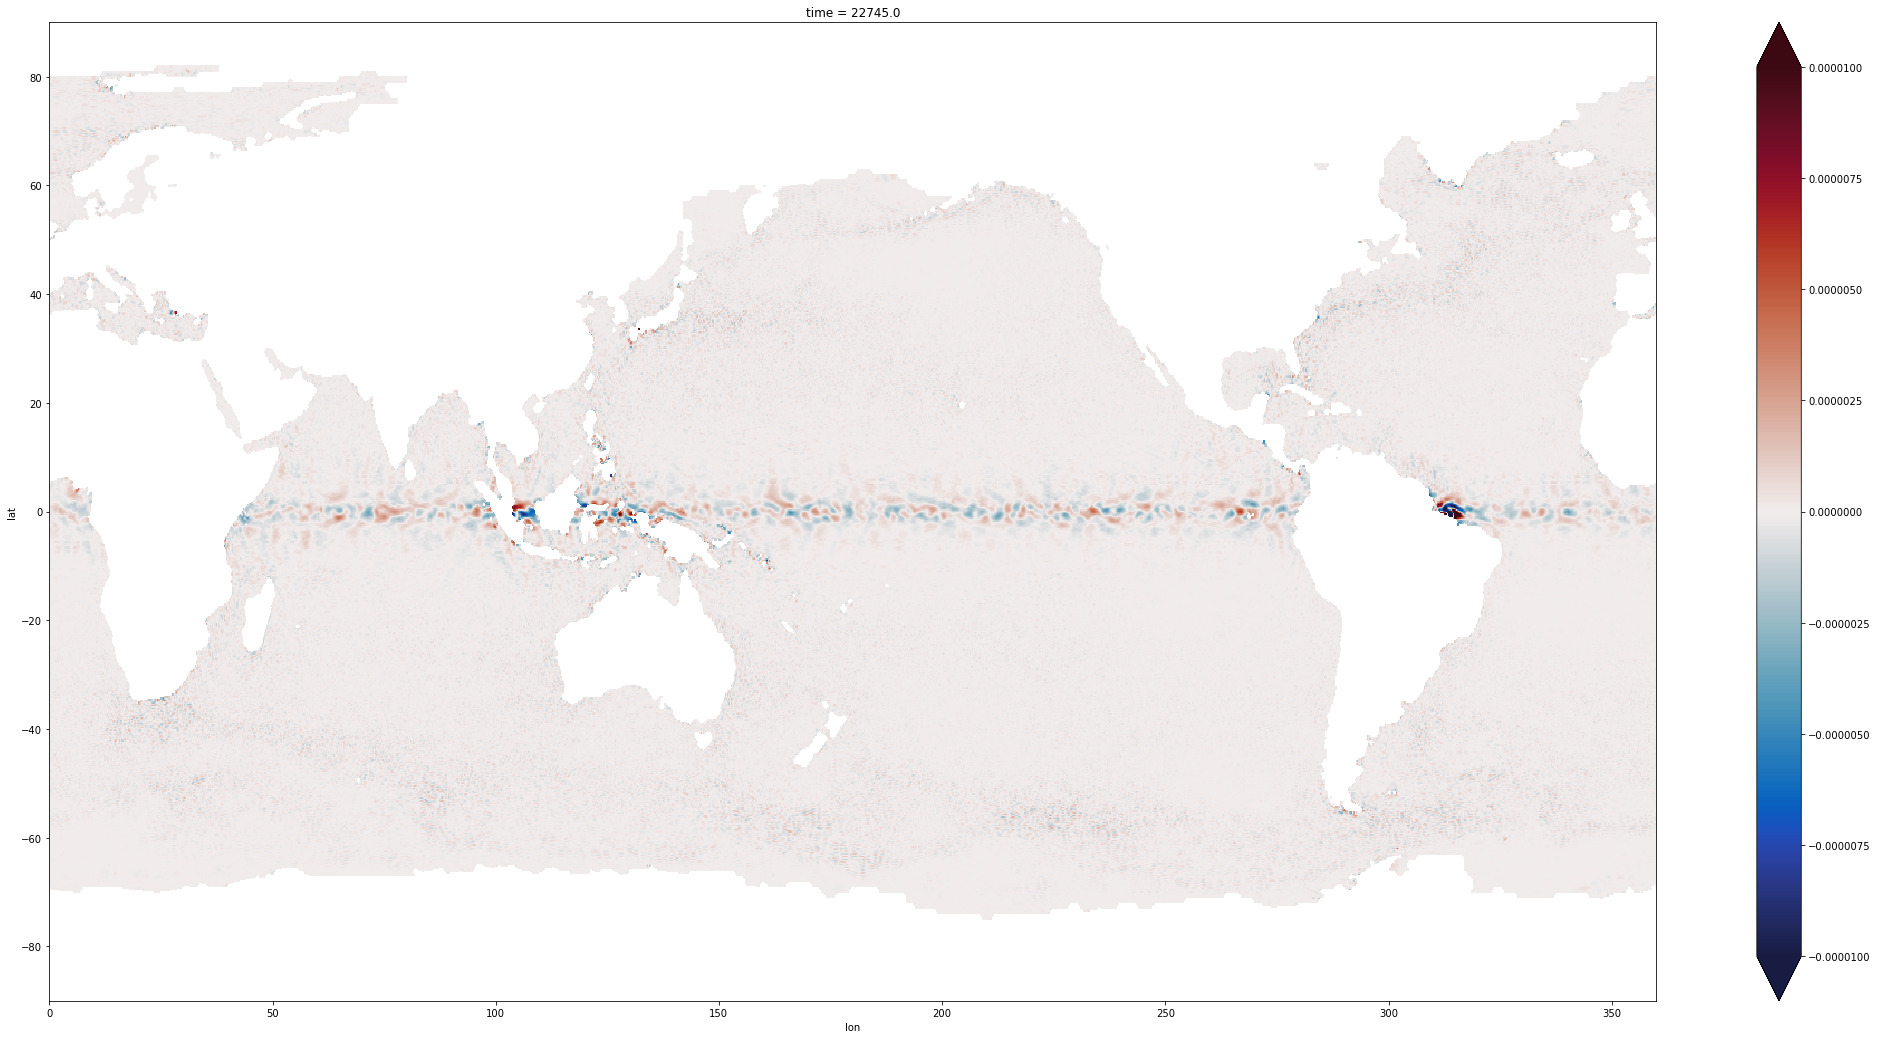

In [61]:
# divergence
fig = plt.figure(figsize=(36,18))
(du_dx_ij+dv_dy_ij).isel(time=100).plot(x='lon',y='lat',vmin=-0.00001,vmax=0.00001,cmap=cm.balance)

### relative vorticity/f

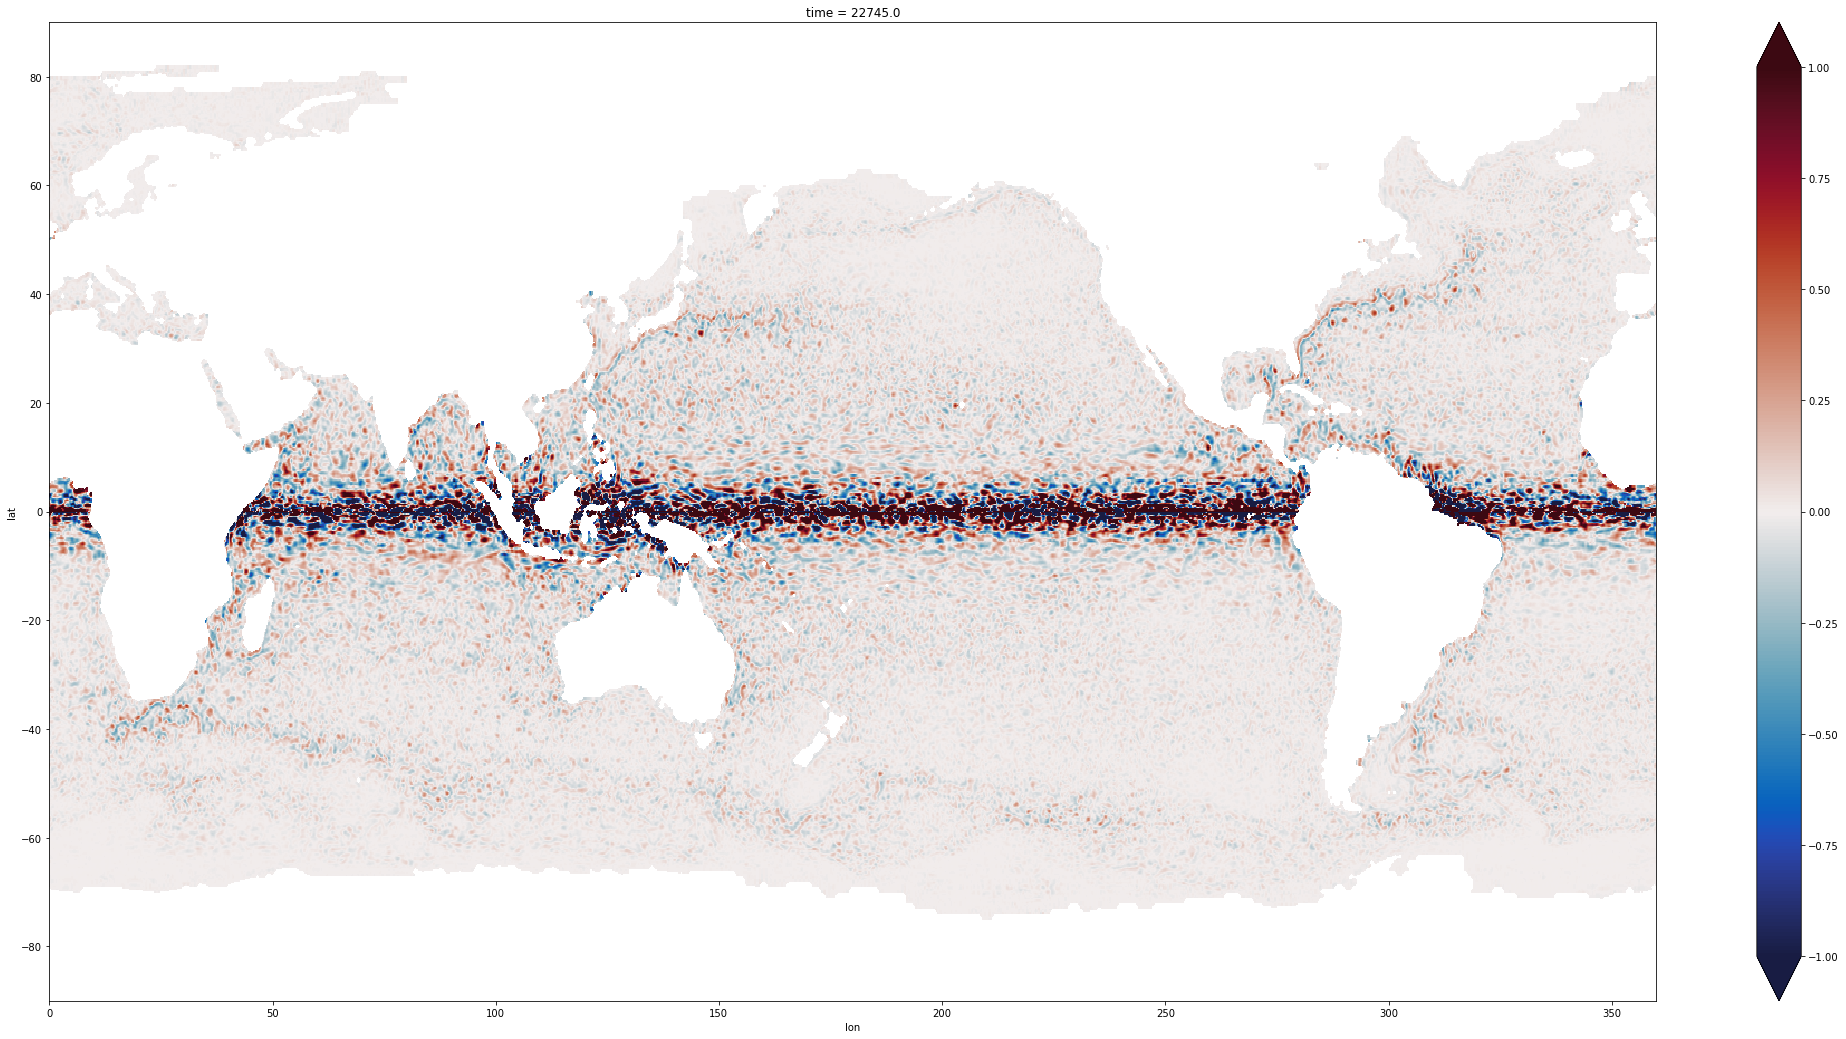

In [62]:
# relative vorticity/f
fig = plt.figure(figsize=(36,18))
((dv_dx_ij-du_dy_ij)/f).isel(time=100).plot(x='lon',y='lat',vmin=-1,vmax=1,cmap=cm.balance)

### Relative vorticity

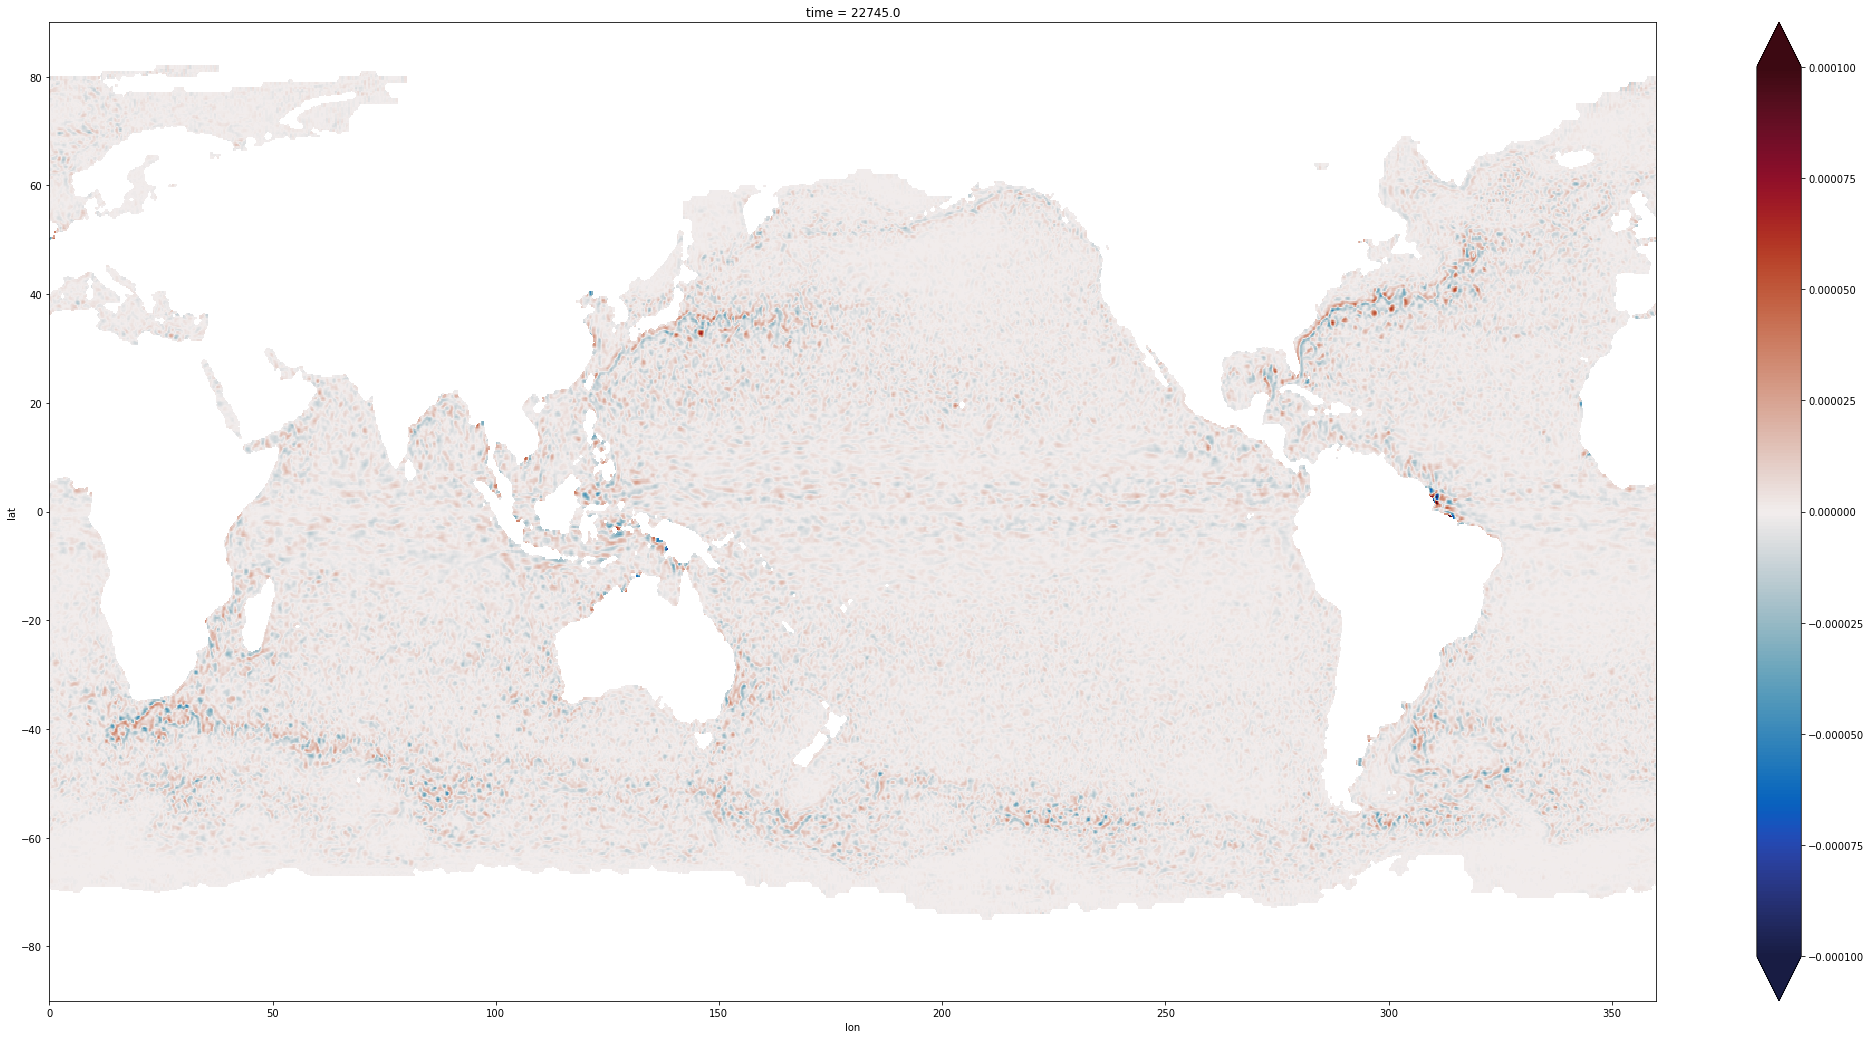

In [63]:
# relative vorticity
fig = plt.figure(figsize=(36,18))
(dv_dx_ij-du_dy_ij).isel(time=100).plot(x='lon',y='lat',vmin=-0.0001,vmax=0.0001,cmap=cm.balance)

### KE

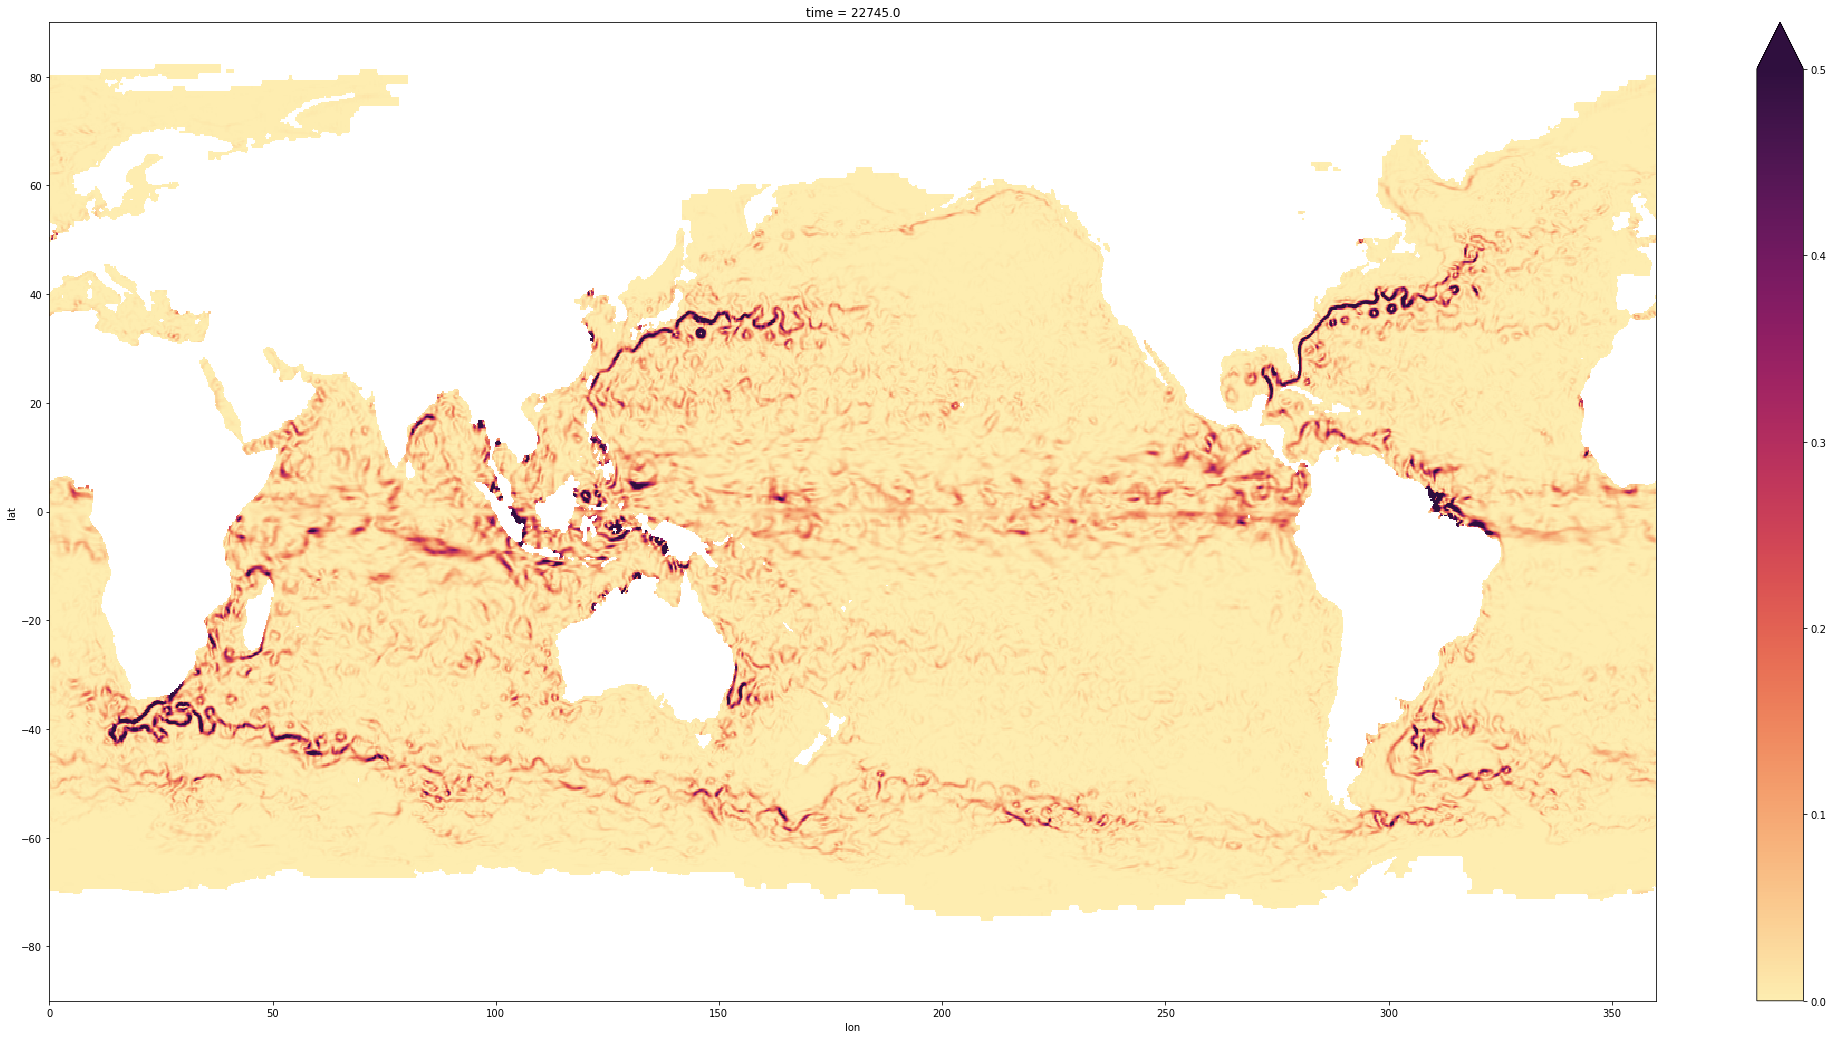

In [64]:
# KE
fig = plt.figure(figsize=(36,18))
(0.5*(ds.v.where(ds.v>-20)**2 + ds.u.where(ds.u>-20)**2)).isel(time=100).plot(x='lon',y='lat',vmin=0,vmax=0.5,cmap=cm.matter)

In [10]:
import cartopy.crs as ccrs
from cmocean import cm

# define (real) time
def iters_to_date(iters, delta_t=24*3600.):
    t0 = datetime.datetime(2012,1,1)    
    ltime = delta_t * (np.array(iters))
    dtime = [t0+dateutil.relativedelta.relativedelta(seconds=t) for t in ltime]    
    return dtime

time_day = iters_to_date(np.arange(731))

KE = 0.5*(ds.v.where(ds.v>-20)**2 + ds.u.where(ds.u>-20)**2)
KE = KE.assign_coords(time=time_day) 
KE

<xarray.DataArray (time: 731, lat: 720, lon: 1440)>
dask.array<mul, shape=(731, 720, 1440), dtype=float64, chunksize=(1, 720, 1440), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -89.875 -89.625 -89.375 ... 89.375 89.625 89.875
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.375 359.625 359.875
  * time     (time) datetime64[ns] 2012-01-01 2012-01-02 ... 2013-12-31

In [10]:
KE_tmean = KE.sel(time=slice('2012-09-05', '2013-09-05')).mean(['time'])
KE_tmean.persist()

<xarray.DataArray (lat: 720, lon: 1440)>
dask.array<mean_agg-aggregate, shape=(720, 1440), dtype=float64, chunksize=(720, 1440), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -89.875 -89.625 -89.375 ... 89.375 89.625 89.875
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.375 359.625 359.875

(330, 360)

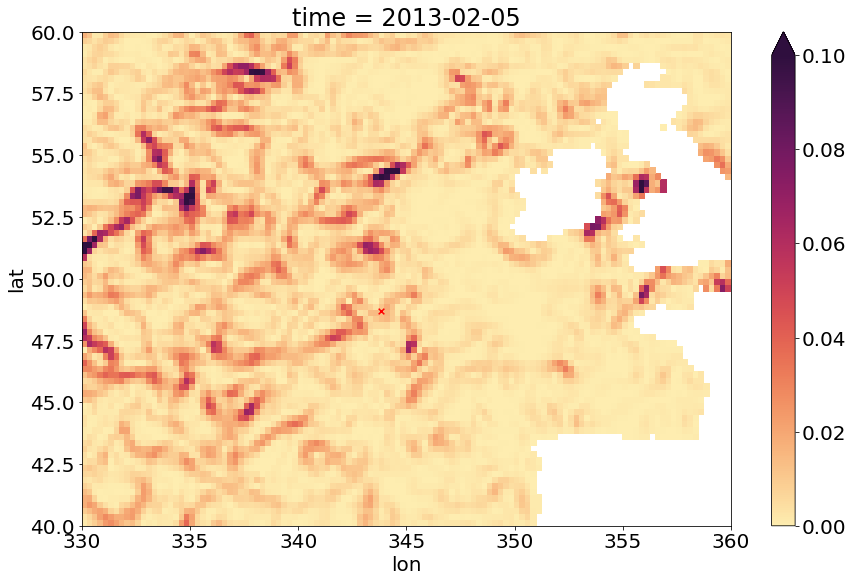

In [14]:
plt.rc('font', size=20) 

font_size=20

fig = plt.figure(figsize=(32,20))

ax = plt.subplot(221)
KE.sel(time='2013-02-05').plot(x='lon',y='lat',vmin=0,vmax=0.1,cmap=cm.matter)
ax.scatter(343.8125,48.6875,s=32,marker='x',color='r')
ax.tick_params(labelsize=font_size)
ax.set_ylim([40, 60.])
ax.set_xlim([360-30, 360])

(330, 360)

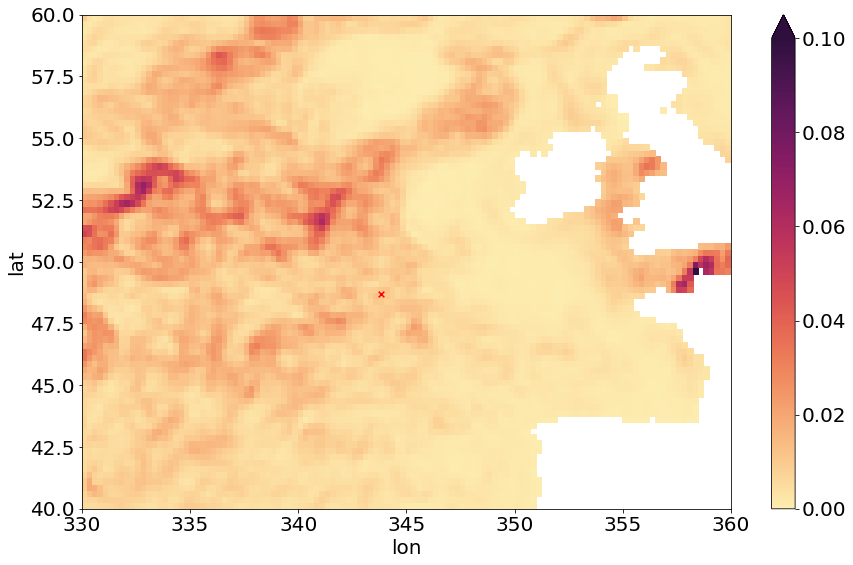

In [13]:
plt.rc('font', size=20) 

font_size=20

fig = plt.figure(figsize=(32,20))

ax = plt.subplot(221)
KE_tmean.plot(x='lon',y='lat',vmin=0,vmax=0.1,cmap=cm.matter)
ax.scatter(343.8125,48.6875,s=32,marker='x',color='r')
ax.tick_params(labelsize=font_size)
ax.set_ylim([40, 60.])
ax.set_xlim([360-30, 360])

(341.97, 345.64)

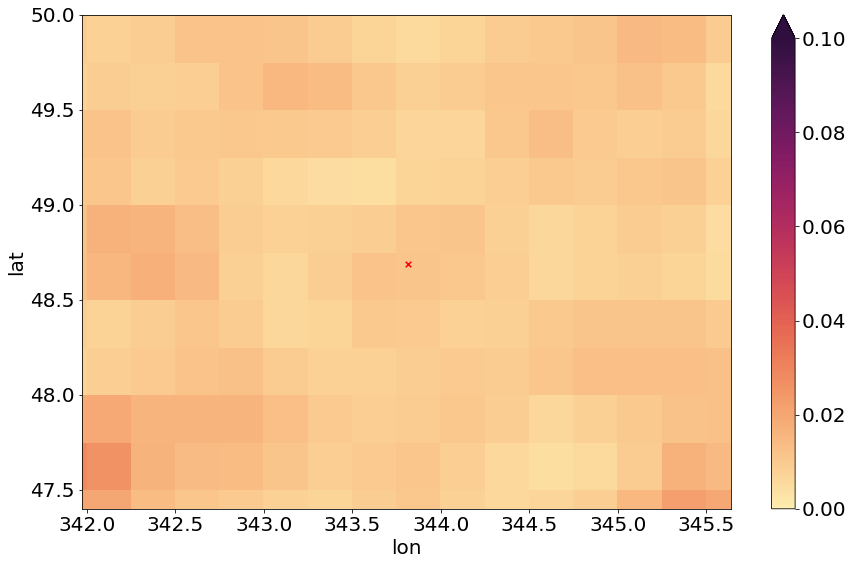

In [11]:
plt.rc('font', size=20) 

font_size=20

fig = plt.figure(figsize=(32,20))

ax = plt.subplot(221)
KE_tmean.plot(x='lon',y='lat',vmin=0,vmax=0.1,cmap=cm.matter)
ax.scatter(343.8125,48.6875,s=32,marker='x',color='r')
ax.tick_params(labelsize=font_size)
ax.set_ylim([47.4, 50.])
ax.set_xlim([360-18.03, 360-14.36])

(330.0, 360.0)

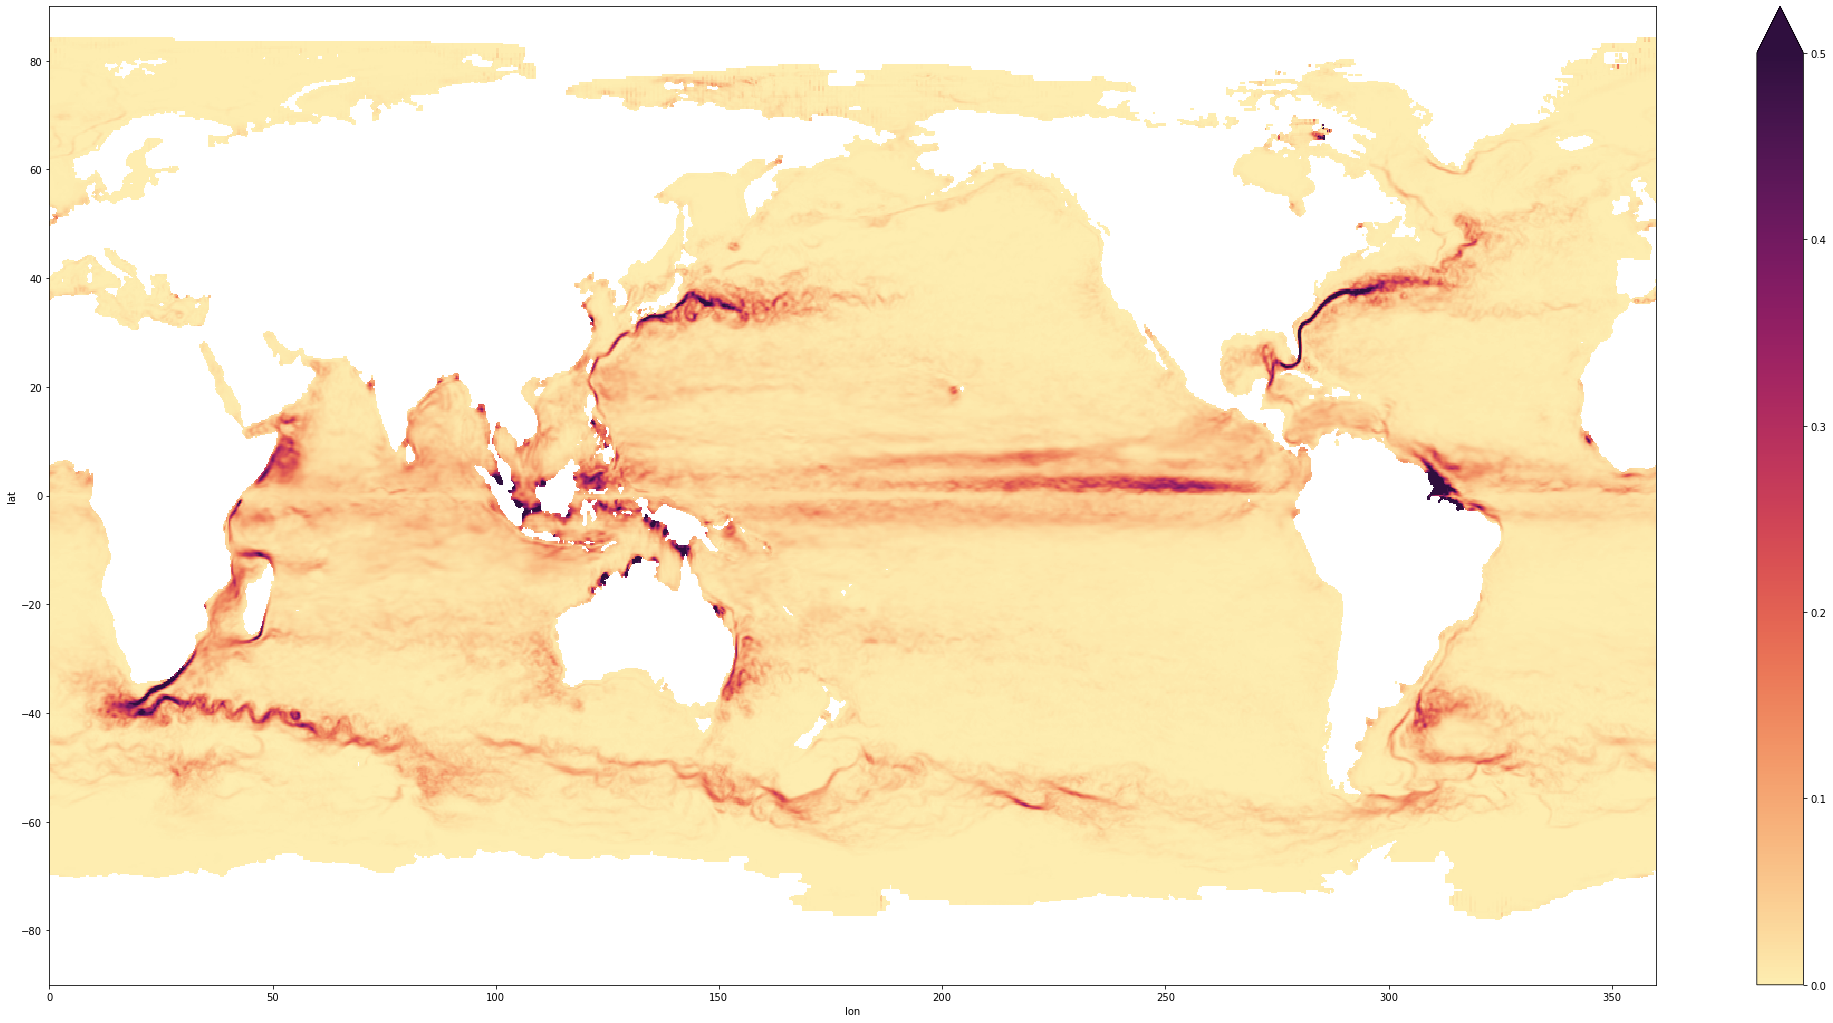

In [25]:
# KE
font_size=20

fig = plt.figure(figsize=(36,18))
KE.sel(time=slice('2012-09-05', '2013-09-05')).mean(['time']).plot(x='lon',y='lat',vmin=0,vmax=0.5,cmap=cm.matter, alpha=0.5)

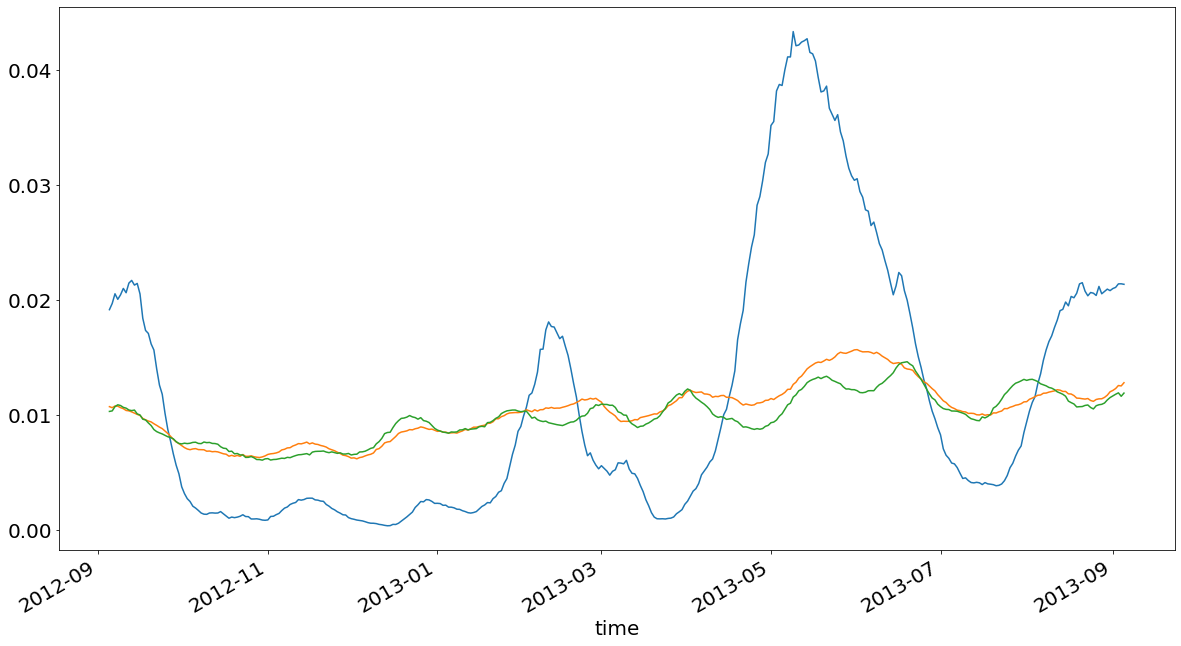

In [54]:
plt.rc('font', size=20) 

font_size=20

fig = plt.figure(figsize=(20,10))

ax = plt.subplot(111)

KE.sel(time=slice('2012-09-05', '2013-09-05')).interp(lat=48.6875,lon=343.8125).plot(x='time')
#KE.sel(time=slice('2012-09-05', '2013-09-05')).sel(lat=48.6875,lon=343.8125,method='nearest').plot(x='time')

KE.sel(time=slice('2012-09-05', '2013-09-05'),lat=slice(47.4,50),lon=slice(360-18.03,360-14.36)).mean(['lat','lon']).plot(x='time')
KE.sel(time=slice('2012-09-05', '2013-09-05'),lat=slice(47.4,50),lon=slice(360-18.03,360-14.36)).std(['lat','lon']).plot(x='time')


In [11]:
KE_aviso = KE.sel(time=slice('2012-09-05', '2013-09-05')).interp(lat=48.6875,lon=343.8125)
KE_aviso

<xarray.DataArray (time: 366)>
dask.array<_interpnd, shape=(366,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2012-09-05 2012-09-06 ... 2013-09-05
    lat      float64 48.69
    lon      float64 343.8

In [12]:
KE_aviso_model = KE.sel(time=slice('2012-09-05', '2013-09-05'),lat=slice(47.4,50),lon=slice(360-18.03,360-14.36))
KE_aviso_model

<xarray.DataArray (time: 366, lat: 10, lon: 15)>
dask.array<getitem, shape=(366, 10, 15), dtype=float64, chunksize=(1, 10, 15), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 47.625 47.875 48.125 48.375 ... 49.375 49.625 49.875
  * lon      (lon) float32 342.125 342.375 342.625 ... 345.125 345.375 345.625
  * time     (time) datetime64[ns] 2012-09-05 2012-09-06 ... 2013-09-05

In [16]:
KE_aviso_sd = np.sqrt( ((KE_aviso_model-KE_aviso)**2).mean(['lat','lon']) )
KE_aviso_sd

<xarray.DataArray (time: 366)>
dask.array<sqrt, shape=(366,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2012-09-05 2012-09-06 ... 2013-09-05

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


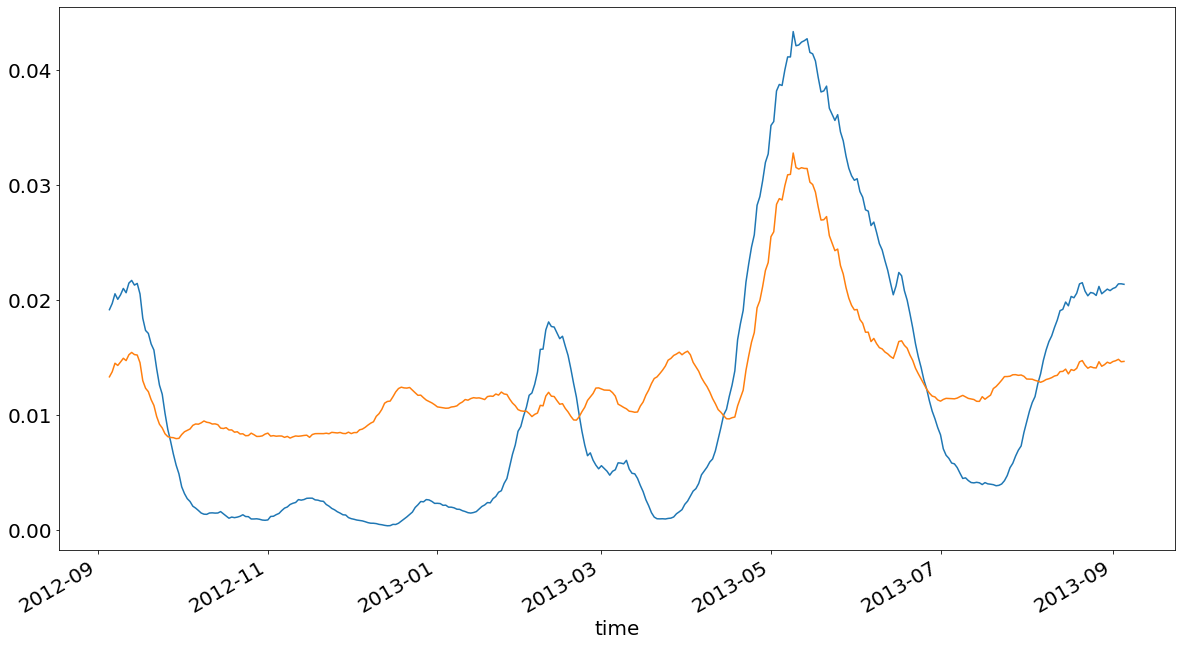

In [17]:
plt.rc('font', size=20) 

font_size=20

fig = plt.figure(figsize=(20,10))

ax = plt.subplot(111)

KE_aviso.plot(x='time')
KE_aviso_sd.plot(x='time')


In [18]:
KE_aviso = KE.sel(time=slice('2012-09-05', '2013-09-05')).interp(lat=48.6875,lon=343.8125)
KE_aviso_sd = KE.sel(time=slice('2012-09-05', '2013-09-05'),lat=slice(47.4,50),lon=slice(360-18.03,360-14.36)).std(['lat','lon'])

KE_aviso = np.real(KE_aviso).rename('KE_aviso')
KE_aviso_sd = np.real(KE_aviso_sd).rename('KE_aviso_sd')

KE_AVISO = xr.merge([KE_aviso,KE_aviso_sd])
KE_AVISO

out_dir_zarr = '/home1/datawork/xyu/OSMOSIS_llc4320/data_store/'

file_out = out_dir_zarr+'/KE_AVISO.nc'
%time KE_AVISO.to_netcdf(file_out, mode='w') 

<xarray.Dataset>
Dimensions:      (time: 366)
Coordinates:
  * time         (time) datetime64[ns] 2012-09-05 2012-09-06 ... 2013-09-05
    lat          float64 48.69
    lon          float64 343.8
Data variables:
    KE_aviso     (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    KE_aviso_sd  (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>

In [53]:
cluster.close()